In [1]:
import sys
if "../../" not in sys.path:
    sys.path.append("../../")

In [122]:
import pandas as pd
import numpy as np
import random
from tqdm import tqdm_notebook as tqdm

import pdaactconn as pc
from trialexplorer import AACTStudySet

import matplotlib.pyplot as plt
%matplotlib inline

from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
# loading all interventional studies
conn = pc.AACTConnection(source=pc.AACTConnection.REMOTE)
ss = AACTStudySet.AACTStudySet(conn=conn, 
                               tqdm_handler=tqdm)
ss.add_constraint("study_type = 'Interventional'")
ss.load_studies()

264682 studies loaded!


In [4]:
# adding and loading dimensional data
ss.add_dimensions(['sponsors',
                   'result_groups'])
ss.refresh_dim_data()

Successfuly added these 2 dimensions: ['sponsors', 'result_groups']
Failed to add these 0 dimensions: []


Syncing the temp table temp_cur_studies in 530 chunks x 500 records each

Creating index on the temp table
 - Loading dimension sponsors
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index


In [5]:
rg = ss.dimensions['result_groups'].data
sp = ss.dimensions['sponsors'].data

In [6]:
sp.head()

,id,agency_class,lead_or_collaborator,name
nct_id,,,,
NCT00000102,4431658,NIH,lead,National Center for Research Resources (NCRR)
NCT00000106,4431142,NIH,lead,National Center for Research Resources (NCRR)
NCT00000108,4431140,NIH,lead,National Center for Research Resources (NCRR)
NCT00000110,4431139,NIH,lead,National Center for Research Resources (NCRR)
NCT00000111,4431138,NIH,lead,National Center for Research Resources (NCRR)


In [7]:
df_ind = sp[(sp['lead_or_collaborator'] == 'lead') & (sp['agency_class'] == 'Industry')]

In [8]:
df_ind.index.unique()

Index(['NCT00000172', 'NCT00000174', 'NCT00000390', 'NCT00000628',
       'NCT00000649', 'NCT00000692', 'NCT00000966', 'NCT00000971',
       'NCT00000980', 'NCT00001017',
       ...
       'NCT04350372', 'NCT04350463', 'NCT04350606', 'NCT04350736',
       'NCT04351152', 'NCT04351165', 'NCT04351243', 'NCT04351555',
       'NCT04351685', 'NCT04351841'],
      dtype='object', name='nct_id', length=74127)

## Loading mapped data

In [9]:
dfmap = pd.read_csv('matched_reconciled.csv')
name2ticker = dfmap.set_index('name')['yf_ticker'].to_dict()

In [10]:
sp['ticker'] = sp['name'].apply(lambda x: name2ticker[x.lower()] if x.lower() in name2ticker.keys() else np.NaN)
sp_sub = sp[sp['lead_or_collaborator'] == 'lead'].dropna()

In [11]:
mapped_nctids = sp_sub.index.unique()

In [12]:
len(mapped_nctids)

35328

## Reducing the dataset to just mapped nct_ids

In [13]:
ss.studies = ss.studies.loc[mapped_nctids]

In [14]:
ss.refresh_dim_data()

Syncing the temp table temp_cur_studies in 71 chunks x 500 records each

Creating index on the temp table
 - Loading dimension sponsors
 -- Loading raw data
 -- Sorting index
 - Loading dimension result_groups
 -- Loading raw data
 -- Sorting index


In [15]:
rg = ss.dimensions['result_groups'].data
sp = ss.dimensions['sponsors'].data

In [16]:
sp['ticker'] = sp['name'].apply(lambda x: name2ticker[x.lower()] if x.lower() in name2ticker.keys() else np.NaN)
sp_sub = sp[sp['lead_or_collaborator'] == 'lead']

In [17]:
# verify that the smaller set has all mapped nctids
pd.isnull(sp_sub['ticker']).sum()

0

### Reading the stock data to determine start and end dates to study

In [18]:
df_stock = pd.read_pickle('stock_data.p')
sd = pd.Timestamp(df_stock.index.values[0])
ed = pd.Timestamp(df_stock.index.values[-1])

In [19]:
sd, ed

(Timestamp('2009-12-30 00:00:00'), Timestamp('2020-04-03 00:00:00'))

## 1. Count the number of studies by company by time

In [20]:
res_col_order = [
    'start_date',
    'start_date_type',
    'primary_completion_date',
    'primary_completion_date_type',
    'results_first_submitted_date',
    'results_first_submitted_qc_date',
    'results_first_posted_date',
    'results_first_posted_date_type',
]

In [21]:
df_sbt = ss.studies[['start_date']].join(sp_sub)
df_sbt['start_date'] = df_sbt['start_date'].apply(lambda x: pd.Timestamp(x))
df_sbt['ones'] = 1
df_sbt = df_sbt[(pd.notnull(df_sbt['start_date'])) & 
                (df_sbt['start_date'] >= sd) & 
                (df_sbt['start_date'] <= ed)]
df_sbt.head()

,start_date,id,agency_class,lead_or_collaborator,name,ticker,ones
nct_id,,,,,,,
NCT00418821,2010-10-31,4377293,Industry,lead,"Genzyme, a Sanofi Company",SAN.PA,1
NCT00422422,2011-07-31,4376898,Industry,lead,UCB Pharma,UCB.BR,1
NCT00427258,2010-01-31,4376390,Industry,lead,"Bausch Health Americas, Inc.",BHC,1
NCT00534339,2010-12-31,4364099,Industry,lead,Allergan Medical,AGN,1
NCT00572585,2010-04-30,4359565,Industry,lead,Novartis Pharmaceuticals,NOVN.SW,1


In [22]:
all_counts = []

for cur_ticker in df_sbt['ticker'].unique():
    cur_df = df_sbt[df_sbt['ticker'] == cur_ticker].sort_values('start_date')
    dfs = cur_df[['start_date', 'ones']].groupby('start_date').sum()
    dfs[cur_ticker] = dfs['ones'].cumsum()
    dfr = dfs[[cur_ticker]].resample('D').ffill()
    all_counts.append(dfr)

In [23]:
df_res_counts = pd.concat(all_counts, axis=1).fillna(method='ffill').fillna(0)
df_res_counts.tail()

,SAN.PA,UCB.BR,BHC,AGN,NOVN.SW,ABT,AZN.ST,PFE,ABBV,ZBH,...,TXMD,MNLO,XERS,ACRS,CL,MYL,RTIX,REPH,CHD,BIM.PA
start_date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,660.0,60.0,157.0,396.0,1394.0,214.0,1005.0,1174.0,448.0,72.0,...,6.0,10.0,14.0,25.0,12.0,23.0,5.0,9.0,14.0,1.0
2020-03-31,661.0,60.0,157.0,397.0,1394.0,216.0,1007.0,1175.0,448.0,72.0,...,6.0,10.0,14.0,25.0,12.0,23.0,5.0,9.0,14.0,1.0
2020-04-01,661.0,60.0,157.0,398.0,1394.0,216.0,1007.0,1175.0,448.0,72.0,...,6.0,10.0,14.0,25.0,12.0,23.0,5.0,9.0,14.0,1.0
2020-04-02,661.0,60.0,157.0,398.0,1395.0,216.0,1007.0,1176.0,448.0,72.0,...,6.0,10.0,14.0,25.0,12.0,23.0,5.0,9.0,14.0,1.0
2020-04-03,661.0,60.0,157.0,398.0,1395.0,216.0,1008.0,1176.0,450.0,72.0,...,6.0,10.0,14.0,25.0,12.0,23.0,5.0,9.0,14.0,1.0


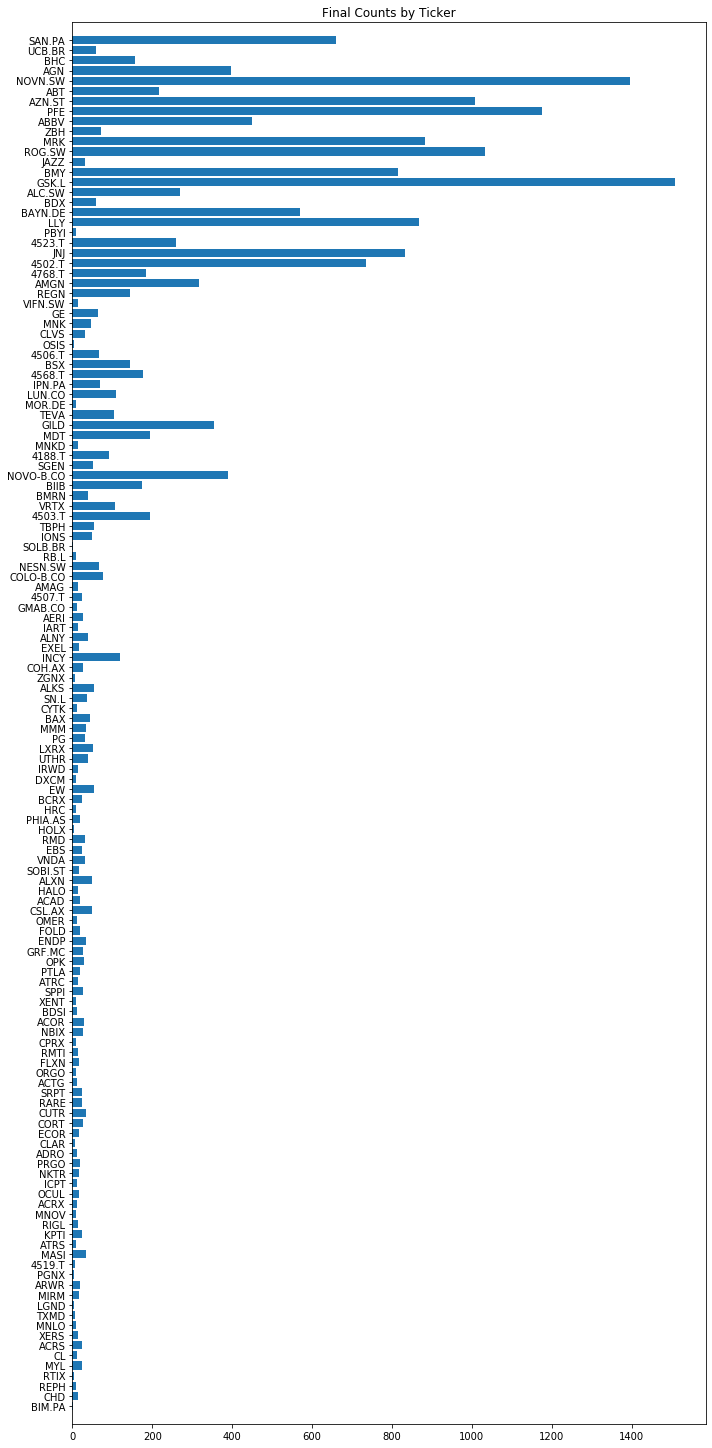

In [24]:
all_last_counts = df_res_counts[-1:].values.ravel()
plt.figure(figsize=(10, 20))
plt.barh(df_res_counts.columns, all_last_counts)
plt.gca().invert_yaxis()
plt.tight_layout()
plt.margins(y=0.01)
plt.title('Final Counts by Ticker')
plt.show()

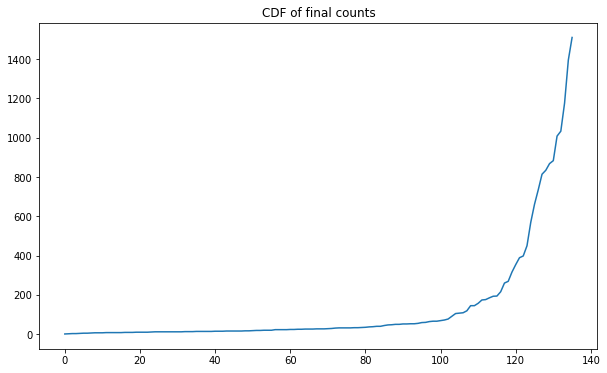

In [25]:
plt.figure(figsize=(10, 6))
plt.plot(sorted(all_last_counts))
plt.title('CDF of final counts')
plt.show()

### control for the market cap sizes of the companies

In [55]:
df_mc = pd.read_pickle('marketcaps.p')
df_mc.head()

,mc,ccy,fx,mc_usd
ticker,,,,
4188.T,873800400896,JPY,0.009178,8.01974e+09
4503.T,2998932602880,JPY,0.009178,2.75242e+10
4506.T,508142845952,JPY,0.009178,4.66374e+09
4507.T,1567943294976,JPY,0.009178,1.43906e+10
4519.T,6800247619584,JPY,0.009178,6.24127e+10


In [56]:
df_last_counts = df_res_counts[-1:].T
df_last_counts.columns = ['final_counts']
df_last_counts.index.name = 'ticker'

In [57]:
dfj = df_last_counts.join(df_mc[['mc_usd']])
dfj.head()

,final_counts,mc_usd
ticker,,
SAN.PA,661.0,1.10015e+11
UCB.BR,60.0,1.63351e+10
BHC,157.0,4.73348e+09
AGN,398.0,5.78089e+10
NOVN.SW,1395.0,1.89229e+11


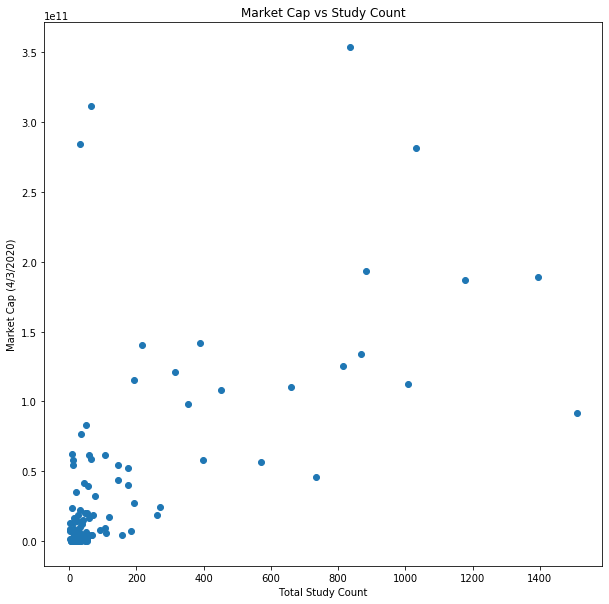

In [58]:
plt.figure(figsize=(10, 10))
plt.scatter(dfj['final_counts'], dfj['mc_usd'])
plt.xlabel('Total Study Count')
plt.ylabel('Market Cap (4/3/2020)')
plt.title("Market Cap vs Study Count")
plt.show()

## Compute the historical Market Caps

In [59]:
df_tri = df_stock / df_stock[-1:].values
df_hist_mc = df_tri * df_mc['mc_usd'].T
df_hist_mc.tail()

,4188.T,4502.T,4503.T,4506.T,4507.T,4519.T,4523.T,4568.T,4578.T,4768.T,...,TXMD,UCB.BR,UTHR,VIFN.SW,VNDA,VRTX,XENT,XERS,ZBH,ZGNX
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,8.705210e+09,4.839533e+10,2.940241e+10,5.258097e+09,1.513242e+10,6.233730e+10,2.059484e+10,4.557249e+10,2.137606e+10,7.978066e+09,...,2.671740e+08,1.565912e+10,4.223936e+09,8.463449e+09,6.790056e+08,5.917369e+10,3.652160e+08,8.858236e+07,2.015934e+10,1.352199e+09
2020-03-31,8.376810e+09,4.786001e+10,2.853160e+10,5.115888e+09,1.482844e+10,6.281469e+10,2.085250e+10,4.420484e+10,2.105753e+10,8.056538e+09,...,2.646770e+08,1.638070e+10,4.126464e+09,8.888782e+09,7.274558e+08,6.071222e+10,3.718049e+08,7.960165e+07,2.073368e+10,1.307267e+09
2020-04-01,8.108356e+09,4.665917e+10,2.743029e+10,4.805944e+09,1.416468e+10,6.075436e+10,1.918819e+10,4.163009e+10,2.030103e+10,7.943189e+09,...,2.496953e+08,1.687005e+10,4.085995e+09,8.838938e+09,6.783034e+08,5.753054e+10,3.303887e+08,7.184559e+07,1.838504e+10,1.221103e+09
2020-04-02,8.060138e+09,4.545833e+10,2.714856e+10,4.714785e+09,1.403919e+10,6.067899e+10,1.853088e+10,4.079761e+10,1.970877e+10,7.803682e+09,...,2.496953e+08,1.633509e+10,4.069895e+09,8.872167e+09,7.737996e+08,6.178639e+10,3.077980e+08,6.368132e+07,1.901681e+10,1.225860e+09
2020-04-03,8.019740e+09,4.583450e+10,2.752420e+10,4.663735e+09,1.439058e+10,6.241267e+10,1.885165e+10,4.025055e+10,1.998251e+10,7.603140e+09,...,2.496953e+08,1.633509e+10,4.069895e+09,8.872167e+09,7.737996e+08,6.178639e+10,3.077980e+08,6.368132e+07,1.901681e+10,1.225860e+09


### Merging everything

In [68]:
has_count_cols = df_res_counts.columns
has_count_cols

Index(['SAN.PA', 'UCB.BR', 'BHC', 'AGN', 'NOVN.SW', 'ABT', 'AZN.ST', 'PFE',
       'ABBV', 'ZBH',
       ...
       'TXMD', 'MNLO', 'XERS', 'ACRS', 'CL', 'MYL', 'RTIX', 'REPH', 'CHD',
       'BIM.PA'],
      dtype='object', name='ticker', length=136)

In [70]:
df_res_counts_mc = df_hist_mc[has_count_cols]

In [71]:
df_res_counts_mc.index.values[-1], df_res_counts_mc.index.values[0]

(numpy.datetime64('2020-04-03T00:00:00.000000000'),
 numpy.datetime64('2009-12-30T00:00:00.000000000'))

In [72]:
df_res_counts.index.values[-1], df_res_counts.index.values[0]

(numpy.datetime64('2020-04-03T00:00:00.000000000'),
 numpy.datetime64('2009-12-30T00:00:00.000000000'))

#### The smaller count does not include weekends so that should be the one that we use

In [73]:
df_res_counts_mc.shape[0], df_res_counts.shape[0]

(2671, 3748)

In [74]:
dfj = df_res_counts_mc.add_suffix("_mc").join(df_res_counts, how='left')

In [75]:
tickers = df_res_counts.columns

for ticker in tickers:
    dfj[ticker + "_factor"] = dfj[ticker] / dfj[ticker + '_mc']
    
df_factor_simple_counts = dfj[[x for x in dfj.columns if '_factor' in x]]    

In [76]:
df_factor_simple_counts.head()

,SAN.PA_factor,UCB.BR_factor,BHC_factor,AGN_factor,NOVN.SW_factor,ABT_factor,AZN.ST_factor,PFE_factor,ABBV_factor,ZBH_factor,...,TXMD_factor,MNLO_factor,XERS_factor,ACRS_factor,CL_factor,MYL_factor,RTIX_factor,REPH_factor,CHD_factor,BIM.PA_factor
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-30,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,NaN,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0
2009-12-31,1.234172e-10,2.161000e-10,2.172655e-10,3.315342e-10,2.116175e-10,6.274937e-11,3.935365e-10,1.979240e-10,NaN,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0
2010-01-04,1.197418e-10,2.152529e-10,2.066094e-10,3.259387e-10,2.187328e-10,6.220783e-11,3.942422e-10,1.901869e-10,NaN,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0
2010-01-05,1.213455e-10,2.133979e-10,2.038324e-10,3.292070e-10,2.225739e-10,6.271451e-11,4.226724e-10,1.929388e-10,NaN,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0
2010-01-06,1.220429e-10,2.130738e-10,4.052139e-10,3.281377e-10,2.221590e-10,6.236816e-11,4.226724e-10,1.935612e-10,NaN,0.0,...,0.0,NaN,NaN,NaN,0.0,0.0,0.0,NaN,0.0,0.0


## 2. Count the number of completed studies by company by time

In [77]:
df_completed = ss.studies[pd.notnull(ss.studies['results_first_submitted_date'])]

df_completed_sp = df_completed[['results_first_submitted_date']].join(sp_sub)
df_completed_sp['results_first_submitted_date'] = df_completed_sp['results_first_submitted_date'].apply(lambda x: pd.Timestamp(x))
df_completed_sp['ones'] = 1

df_completed_sp = df_completed_sp[(pd.notnull(df_completed_sp['results_first_submitted_date'])) & 
                                  (df_completed_sp['results_first_submitted_date'] >= sd) & 
                                  (df_completed_sp['results_first_submitted_date'] <= ed)]
df_completed_sp.head()

,results_first_submitted_date,id,agency_class,lead_or_collaborator,name,ticker,ones
nct_id,,,,,,,
NCT00009737,2016-05-16,4418853,Industry,lead,Hoffmann-La Roche,ROG.SW,1
NCT00021255,2016-06-15,4423980,Industry,lead,Sanofi,SAN.PA,1
NCT00022672,2013-04-02,4423918,Industry,lead,Hoffmann-La Roche,ROG.SW,1
NCT00022698,2016-03-16,4423915,Industry,lead,Hoffmann-La Roche,ROG.SW,1
NCT00022763,2015-12-04,4427580,Industry,lead,Hoffmann-La Roche,ROG.SW,1


In [78]:
df_completed_sp.shape

(12914, 7)

In [79]:
all_counts_completed = []

for cur_ticker in df_completed_sp['ticker'].unique():
    cur_df = df_completed_sp[df_completed_sp['ticker'] == cur_ticker].sort_values('results_first_submitted_date')
    dfs = cur_df[['results_first_submitted_date', 'ones']].groupby('results_first_submitted_date').sum()
    dfs[cur_ticker] = dfs['ones'].cumsum()
    dfr = dfs[[cur_ticker]].resample('D').ffill()
    all_counts_completed.append(dfr)

In [80]:
df_res_completed = pd.concat(all_counts_completed, axis=1).fillna(method='ffill').fillna(0)
df_res_completed.tail()

,ROG.SW,SAN.PA,BMY,PFE,ACOR,PG,AMGN,4506.T,NOVN.SW,4502.T,...,TXMD,XERS,ACRS,MASI,ARWR,MYL,KPTI,REPH,CHD,MNLO
results_first_submitted_date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,700.0,368.0,373.0,906.0,24.0,24.0,258.0,56.0,1105.0,622,...,3.0,9.0,15.0,29.0,9.0,7.0,2.0,5.0,9.0,3.0
2020-03-31,700.0,369.0,373.0,906.0,24.0,24.0,258.0,56.0,1105.0,622,...,3.0,9.0,15.0,29.0,9.0,7.0,2.0,5.0,9.0,3.0
2020-04-01,700.0,369.0,373.0,906.0,24.0,24.0,258.0,56.0,1106.0,622,...,3.0,9.0,15.0,29.0,9.0,7.0,2.0,5.0,9.0,3.0
2020-04-02,700.0,369.0,373.0,906.0,24.0,24.0,258.0,56.0,1106.0,622,...,3.0,9.0,15.0,29.0,9.0,7.0,2.0,5.0,9.0,3.0
2020-04-03,700.0,369.0,373.0,906.0,24.0,24.0,258.0,56.0,1106.0,623,...,3.0,9.0,15.0,29.0,9.0,7.0,2.0,5.0,9.0,3.0


In [81]:
df_res_completed.shape

(3748, 134)

### Fill in the last dates that are missing by ffill. Missing dates because nothing completed in the last x days

In [168]:
dt_idx = pd.date_range(start=df_res_completed.index[-1] + pd.Timedelta(days=1), 
                       end=df_hist_mc.index[-1], freq='D')

if len(dt_idx) > 0:
    final_array = df_res_completed[-1:].values
    for i in range(len(dt_idx)-1):
        final_array = np.append(final_array, df_res_completed[-1:].values, axis=0)

    df_pad = pd.DataFrame(final_array, index=dt_idx, columns = df_res_completed.columns)

In [87]:
if len(dt_idx) > 0:
    df_res_completed = pd.concat([df_res_completed, df_pad])
else:
    pass

In [88]:
has_complete_cols = df_res_completed.columns
df_res_completed_mc = df_hist_mc[has_complete_cols]
dfj_completed = df_res_completed_mc.add_suffix("_mc").join(df_res_completed, how='left')

In [89]:
tickers = df_res_completed.columns

for ticker in tickers:
    dfj_completed[ticker + "_factor"] = dfj_completed[ticker] / dfj_completed[ticker + '_mc']
    
df_factor_completed = dfj_completed[[x for x in dfj_completed.columns if '_factor' in x]]    

In [90]:
df_factor_completed.tail()

,ROG.SW_factor,SAN.PA_factor,BMY_factor,PFE_factor,ACOR_factor,PG_factor,AMGN_factor,4506.T_factor,NOVN.SW_factor,4502.T_factor,...,TXMD_factor,XERS_factor,ACRS_factor,MASI_factor,ARWR_factor,MYL_factor,KPTI_factor,REPH_factor,CHD_factor,MNLO_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,2.597749e-09,3.302194e-09,3.038631e-09,4.884437e-09,4.969641e-07,8.401161e-11,2.133638e-09,1.065024e-08,6.063169e-09,1.285248e-08,...,1.122864e-08,1.016004e-07,3.573321e-07,3.026985e-09,3.148531e-09,9.116721e-10,1.547165e-09,2.687204e-08,5.534905e-10,1.902955e-08
2020-03-31,2.554323e-09,3.326455e-09,2.965037e-09,4.888926e-09,5.236826e-07,8.783032e-11,2.194154e-09,1.094629e-08,5.907509e-09,1.299624e-08,...,1.133457e-08,1.130630e-07,3.504603e-07,3.072103e-09,3.170419e-09,9.214553e-10,1.612402e-09,2.631289e-08,5.589236e-10,1.867452e-08
2020-04-01,2.516264e-09,3.377022e-09,3.014797e-09,5.025970e-09,6.087811e-07,8.836857e-11,2.248728e-09,1.165224e-08,5.984049e-09,1.333071e-08,...,1.201464e-08,1.252686e-07,3.504603e-07,3.048523e-09,3.439402e-09,9.634571e-10,1.715075e-09,3.057985e-08,5.622527e-10,2.094047e-08
2020-04-02,2.485854e-09,3.354078e-09,2.968928e-09,4.854717e-09,5.729704e-07,8.445223e-11,2.129552e-09,1.187753e-08,5.844781e-09,1.368286e-08,...,1.201464e-08,1.413287e-07,3.283592e-07,2.960128e-09,3.389556e-09,9.869898e-10,1.712230e-09,3.006662e-08,5.412965e-10,1.895747e-08
2020-04-03,2.485854e-09,3.354078e-09,2.968928e-09,4.854717e-09,5.729704e-07,8.445223e-11,2.129552e-09,1.200754e-08,5.844781e-09,1.359238e-08,...,1.201464e-08,1.413287e-07,3.283592e-07,2.960128e-09,3.389556e-09,9.869898e-10,1.712230e-09,3.006662e-08,5.412965e-10,1.895747e-08


## 3. Count the number of studies that went to phase 3 by time

In [91]:
ss.studies['phase'].unique()

array(['Phase 3', 'Phase 1', 'Phase 2', 'N/A', 'Phase 4',
       'Phase 2/Phase 3', 'Phase 1/Phase 2', 'Early Phase 1'],
      dtype=object)

In [92]:
accepted_phases = ['Phase 3', 'Phase 2/Phase 3']

In [93]:
df_p3 = ss.studies[ss.studies['phase'].isin(accepted_phases)].copy()

df_p3_sp = df_p3[['start_date']].join(sp_sub)
df_p3_sp['start_date'] = df_p3_sp['start_date'].apply(lambda x: pd.Timestamp(x))
df_p3_sp['ones'] = 1

df_p3_sp = df_p3_sp[(pd.notnull(df_p3_sp['start_date'])) & 
              (df_p3_sp['start_date'] >= sd) & 
              (df_p3_sp['start_date'] <= ed)]

df_p3_sp.head()

,start_date,id,agency_class,lead_or_collaborator,name,ticker,ones
nct_id,,,,,,,
NCT00628303,2010-10-31,4352810,Industry,lead,MedImmune LLC,AZN.ST,1
NCT00660387,2009-12-31,4349216,Industry,lead,"AbbVie (prior sponsor, Abbott)",ABBV,1
NCT00764478,2012-04-06,4337169,Industry,lead,Merck Sharp & Dohme Corp.,MRK,1
NCT00770133,2010-02-28,4336549,Industry,lead,Bausch & Lomb Incorporated,BHC,1
NCT00796510,2010-07-31,4333630,Industry,lead,Pfizer,PFE,1


In [94]:
all_counts_p3 = []

for cur_ticker in df_p3_sp['ticker'].unique():
    cur_df = df_p3_sp[df_p3_sp['ticker'] == cur_ticker].sort_values('start_date')
    dfs = cur_df[['start_date', 'ones']].groupby('start_date').sum()
    dfs[cur_ticker] = dfs['ones'].cumsum()
    dfr = dfs[[cur_ticker]].resample('D').ffill()
    all_counts_p3.append(dfr)

In [95]:
df_res_p3 = pd.concat(all_counts_p3, axis=1).fillna(method='ffill').fillna(0)
df_res_p3.tail()

,AZN.ST,ABBV,MRK,BHC,PFE,JAZZ,GSK.L,ALC.SW,BAYN.DE,AGN,...,RMD,EW,HALO,MOR.DE,PGNX,MIRM,PG,MNLO,ARWR,MNOV
start_date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,231.0,181.0,348.0,62.0,229.0,11.0,355.0,34.0,120.0,144.0,...,2.0,2.0,1.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0
2020-03-31,232.0,181.0,348.0,62.0,229.0,11.0,355.0,34.0,120.0,145.0,...,2.0,2.0,1.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0
2020-04-01,232.0,181.0,348.0,62.0,229.0,11.0,355.0,34.0,120.0,145.0,...,2.0,2.0,1.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0
2020-04-02,232.0,181.0,348.0,62.0,229.0,11.0,357.0,34.0,120.0,145.0,...,2.0,2.0,1.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0
2020-04-03,232.0,182.0,348.0,62.0,229.0,11.0,357.0,34.0,120.0,145.0,...,2.0,2.0,1.0,1.0,2.0,3.0,2.0,3.0,1.0,1.0


In [96]:
has_p3_cols = df_res_p3.columns
df_res_p3_mc = df_hist_mc[has_p3_cols]
dfj_p3 = df_res_p3_mc.add_suffix("_mc").join(df_res_p3, how='left')

In [97]:
tickers = df_res_p3.columns

for ticker in tickers:
    dfj_p3[ticker + "_factor"] = dfj_p3[ticker] / dfj_p3[ticker + '_mc']
    
df_factor_p3 = dfj_p3[[x for x in dfj_p3.columns if '_factor' in x]]    

In [98]:
df_factor_p3.tail()

,AZN.ST_factor,ABBV_factor,MRK_factor,BHC_factor,PFE_factor,JAZZ_factor,GSK.L_factor,ALC.SW_factor,BAYN.DE_factor,AGN_factor,...,RMD_factor,EW_factor,HALO_factor,MOR.DE_factor,PGNX_factor,MIRM_factor,PG_factor,MNLO_factor,ARWR_factor,MNOV_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,2.052582e-09,1.668173e-09,1.797597e-09,1.166384e-08,1.234587e-09,1.982831e-09,3.911369e-09,1.373530e-09,2.126023e-09,2.508342e-09,...,8.801554e-11,4.810692e-11,4.135916e-10,3.158423e-10,6.822276e-09,8.685587e-09,7.000968e-12,1.902955e-08,3.498368e-10,6.919780e-09
2020-03-31,2.036192e-09,1.647373e-09,1.797831e-09,1.147571e-08,1.235722e-09,1.980048e-09,3.827181e-09,1.356963e-09,2.119184e-09,2.514494e-09,...,9.215070e-11,5.000447e-11,4.179597e-10,3.184729e-10,6.624789e-09,8.679383e-09,7.319194e-12,1.867452e-08,3.522688e-10,6.715163e-09
2020-04-01,2.050493e-09,1.709526e-09,1.874324e-09,1.293626e-08,1.270361e-09,2.064067e-09,3.865979e-09,1.361379e-09,2.139833e-09,2.546123e-09,...,9.538883e-11,5.463617e-11,4.607289e-10,3.161906e-10,7.339417e-09,1.055702e-08,7.364047e-12,2.094047e-08,3.821558e-10,7.219770e-09
2020-04-02,2.067590e-09,1.670616e-09,1.799468e-09,1.309820e-08,1.227075e-09,1.984225e-09,3.903902e-09,1.406872e-09,2.119184e-09,2.508262e-09,...,9.040749e-11,5.102154e-11,4.457081e-10,3.258178e-10,7.698532e-09,9.318356e-09,7.037686e-12,1.895747e-08,3.766173e-10,7.434645e-09
2020-04-03,2.067590e-09,1.679846e-09,1.799468e-09,1.309820e-08,1.227075e-09,1.984225e-09,3.903902e-09,1.406872e-09,2.119184e-09,2.508262e-09,...,9.040749e-11,5.102154e-11,4.457081e-10,3.258178e-10,7.698532e-09,9.318356e-09,7.037686e-12,1.895747e-08,3.766173e-10,7.434645e-09


## 4. Simple top decile vs bottom decile return for each group

In [99]:
df_factor_simple_counts.tail()

,SAN.PA_factor,UCB.BR_factor,BHC_factor,AGN_factor,NOVN.SW_factor,ABT_factor,AZN.ST_factor,PFE_factor,ABBV_factor,ZBH_factor,...,TXMD_factor,MNLO_factor,XERS_factor,ACRS_factor,CL_factor,MYL_factor,RTIX_factor,REPH_factor,CHD_factor,BIM.PA_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,5.922414e-09,3.831632e-09,2.953585e-08,6.897940e-09,7.648921e-09,1.529356e-09,8.930066e-09,6.329282e-09,4.128960e-09,3.571546e-09,...,2.245727e-08,6.343183e-08,1.580450e-07,5.955535e-07,2.119084e-10,2.995494e-09,4.194331e-08,4.836968e-08,8.609852e-10,7.759311e-11
2020-03-31,5.958772e-09,3.662846e-09,2.905946e-08,6.884511e-09,7.452549e-09,1.552061e-09,8.838128e-09,6.340495e-09,4.077476e-09,3.472611e-09,...,2.266914e-08,6.224840e-08,1.758757e-07,5.841005e-07,2.126110e-10,3.027639e-09,4.120746e-08,4.736321e-08,8.694368e-10,7.577806e-11
2020-04-01,6.049354e-09,3.556598e-09,3.275794e-08,6.988668e-09,7.542282e-09,1.599493e-09,8.900199e-09,6.518228e-09,4.231312e-09,3.916228e-09,...,2.402928e-08,6.980155e-08,1.948623e-07,5.841005e-07,2.152382e-10,3.165645e-09,4.431746e-08,5.504373e-08,8.746152e-10,7.172351e-11
2020-04-02,6.008253e-09,3.673075e-09,3.316802e-08,6.884748e-09,7.372034e-09,1.541706e-09,8.974410e-09,6.301487e-09,4.135005e-09,3.786124e-09,...,2.402928e-08,6.319156e-08,2.198447e-07,5.472653e-07,2.069659e-10,3.242967e-09,4.546113e-08,5.411992e-08,8.420168e-10,7.585199e-11
2020-04-03,6.008253e-09,3.673075e-09,3.316802e-08,6.884748e-09,7.372034e-09,1.541706e-09,8.983322e-09,6.301487e-09,4.153465e-09,3.786124e-09,...,2.402928e-08,6.319156e-08,2.198447e-07,5.472653e-07,2.069659e-10,3.242967e-09,4.546113e-08,5.411992e-08,8.420168e-10,7.585199e-11


In [100]:
df_factor_completed.tail()

,ROG.SW_factor,SAN.PA_factor,BMY_factor,PFE_factor,ACOR_factor,PG_factor,AMGN_factor,4506.T_factor,NOVN.SW_factor,4502.T_factor,...,TXMD_factor,XERS_factor,ACRS_factor,MASI_factor,ARWR_factor,MYL_factor,KPTI_factor,REPH_factor,CHD_factor,MNLO_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,2.597749e-09,3.302194e-09,3.038631e-09,4.884437e-09,4.969641e-07,8.401161e-11,2.133638e-09,1.065024e-08,6.063169e-09,1.285248e-08,...,1.122864e-08,1.016004e-07,3.573321e-07,3.026985e-09,3.148531e-09,9.116721e-10,1.547165e-09,2.687204e-08,5.534905e-10,1.902955e-08
2020-03-31,2.554323e-09,3.326455e-09,2.965037e-09,4.888926e-09,5.236826e-07,8.783032e-11,2.194154e-09,1.094629e-08,5.907509e-09,1.299624e-08,...,1.133457e-08,1.130630e-07,3.504603e-07,3.072103e-09,3.170419e-09,9.214553e-10,1.612402e-09,2.631289e-08,5.589236e-10,1.867452e-08
2020-04-01,2.516264e-09,3.377022e-09,3.014797e-09,5.025970e-09,6.087811e-07,8.836857e-11,2.248728e-09,1.165224e-08,5.984049e-09,1.333071e-08,...,1.201464e-08,1.252686e-07,3.504603e-07,3.048523e-09,3.439402e-09,9.634571e-10,1.715075e-09,3.057985e-08,5.622527e-10,2.094047e-08
2020-04-02,2.485854e-09,3.354078e-09,2.968928e-09,4.854717e-09,5.729704e-07,8.445223e-11,2.129552e-09,1.187753e-08,5.844781e-09,1.368286e-08,...,1.201464e-08,1.413287e-07,3.283592e-07,2.960128e-09,3.389556e-09,9.869898e-10,1.712230e-09,3.006662e-08,5.412965e-10,1.895747e-08
2020-04-03,2.485854e-09,3.354078e-09,2.968928e-09,4.854717e-09,5.729704e-07,8.445223e-11,2.129552e-09,1.200754e-08,5.844781e-09,1.359238e-08,...,1.201464e-08,1.413287e-07,3.283592e-07,2.960128e-09,3.389556e-09,9.869898e-10,1.712230e-09,3.006662e-08,5.412965e-10,1.895747e-08


In [101]:
df_factor_p3.tail()

,AZN.ST_factor,ABBV_factor,MRK_factor,BHC_factor,PFE_factor,JAZZ_factor,GSK.L_factor,ALC.SW_factor,BAYN.DE_factor,AGN_factor,...,RMD_factor,EW_factor,HALO_factor,MOR.DE_factor,PGNX_factor,MIRM_factor,PG_factor,MNLO_factor,ARWR_factor,MNOV_factor
Date,,,,,,,,,,,,,,,,,,,,,
2020-03-30,2.052582e-09,1.668173e-09,1.797597e-09,1.166384e-08,1.234587e-09,1.982831e-09,3.911369e-09,1.373530e-09,2.126023e-09,2.508342e-09,...,8.801554e-11,4.810692e-11,4.135916e-10,3.158423e-10,6.822276e-09,8.685587e-09,7.000968e-12,1.902955e-08,3.498368e-10,6.919780e-09
2020-03-31,2.036192e-09,1.647373e-09,1.797831e-09,1.147571e-08,1.235722e-09,1.980048e-09,3.827181e-09,1.356963e-09,2.119184e-09,2.514494e-09,...,9.215070e-11,5.000447e-11,4.179597e-10,3.184729e-10,6.624789e-09,8.679383e-09,7.319194e-12,1.867452e-08,3.522688e-10,6.715163e-09
2020-04-01,2.050493e-09,1.709526e-09,1.874324e-09,1.293626e-08,1.270361e-09,2.064067e-09,3.865979e-09,1.361379e-09,2.139833e-09,2.546123e-09,...,9.538883e-11,5.463617e-11,4.607289e-10,3.161906e-10,7.339417e-09,1.055702e-08,7.364047e-12,2.094047e-08,3.821558e-10,7.219770e-09
2020-04-02,2.067590e-09,1.670616e-09,1.799468e-09,1.309820e-08,1.227075e-09,1.984225e-09,3.903902e-09,1.406872e-09,2.119184e-09,2.508262e-09,...,9.040749e-11,5.102154e-11,4.457081e-10,3.258178e-10,7.698532e-09,9.318356e-09,7.037686e-12,1.895747e-08,3.766173e-10,7.434645e-09
2020-04-03,2.067590e-09,1.679846e-09,1.799468e-09,1.309820e-08,1.227075e-09,1.984225e-09,3.903902e-09,1.406872e-09,2.119184e-09,2.508262e-09,...,9.040749e-11,5.102154e-11,4.457081e-10,3.258178e-10,7.698532e-09,9.318356e-09,7.037686e-12,1.895747e-08,3.766173e-10,7.434645e-09


## forming a baseline 

- Market cap weighted returns

In [102]:
df_hist_mc

,4188.T,4502.T,4503.T,4506.T,4507.T,4519.T,4523.T,4568.T,4578.T,4768.T,...,TXMD,UCB.BR,UTHR,VIFN.SW,VNDA,VRTX,XENT,XERS,ZBH,ZGNX
Date,,,,,,,,,,,,,,,,,,,,,
2009-12-30,3.761805e+09,3.656650e+10,4.922616e+09,3.051218e+09,4.539156e+09,7.289304e+09,6.454352e+09,8.602947e+09,NaN,5.767705e+08,...,2.746649e+10,4.776352e+09,2.281456e+09,5.998600e+08,8.110150e+08,1.111165e+10,NaN,NaN,1.139725e+10,NaN
2009-12-31,3.761805e+09,3.656650e+10,4.922616e+09,3.051218e+09,4.539156e+09,7.289304e+09,6.454352e+09,8.602947e+09,NaN,5.767705e+08,...,3.246039e+10,4.627487e+09,2.291029e+09,5.998600e+08,7.899497e+08,1.093305e+10,NaN,NaN,1.127329e+10,NaN
2010-01-04,3.752257e+09,3.675745e+10,4.936842e+09,3.060597e+09,4.523349e+09,7.297681e+09,6.482661e+09,8.602947e+09,NaN,5.767705e+08,...,3.745430e+10,4.645699e+09,2.325406e+09,6.138568e+08,8.194411e+08,1.128770e+10,NaN,NaN,1.144684e+10,NaN
2010-01-05,3.799997e+09,3.694841e+10,4.979524e+09,3.076228e+09,4.532382e+09,7.192950e+09,6.463789e+09,8.651502e+09,NaN,5.854901e+08,...,3.745430e+10,4.686082e+09,2.318008e+09,6.182557e+08,7.920562e+08,1.091519e+10,NaN,NaN,1.180920e+10,NaN
2010-01-06,3.799997e+09,3.694841e+10,4.979524e+09,3.098112e+09,4.532382e+09,7.255791e+09,6.529842e+09,8.651502e+09,NaN,5.967017e+08,...,3.420826e+10,4.693209e+09,2.354125e+09,6.130570e+08,7.716930e+08,1.072383e+10,NaN,NaN,1.180539e+10,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-03-30,8.705210e+09,4.839533e+10,2.940241e+10,5.258097e+09,1.513242e+10,6.233730e+10,2.059484e+10,4.557249e+10,2.137606e+10,7.978066e+09,...,2.671740e+08,1.565912e+10,4.223936e+09,8.463449e+09,6.790056e+08,5.917369e+10,3.652160e+08,8.858236e+07,2.015934e+10,1.352199e+09
2020-03-31,8.376810e+09,4.786001e+10,2.853160e+10,5.115888e+09,1.482844e+10,6.281469e+10,2.085250e+10,4.420484e+10,2.105753e+10,8.056538e+09,...,2.646770e+08,1.638070e+10,4.126464e+09,8.888782e+09,7.274558e+08,6.071222e+10,3.718049e+08,7.960165e+07,2.073368e+10,1.307267e+09
2020-04-01,8.108356e+09,4.665917e+10,2.743029e+10,4.805944e+09,1.416468e+10,6.075436e+10,1.918819e+10,4.163009e+10,2.030103e+10,7.943189e+09,...,2.496953e+08,1.687005e+10,4.085995e+09,8.838938e+09,6.783034e+08,5.753054e+10,3.303887e+08,7.184559e+07,1.838504e+10,1.221103e+09


In [103]:
all_rts = {}
for i in range(df_hist_mc.shape[0] - 1):
    cur_df = df_hist_mc[i:i+2].dropna(axis=1)
    cur_idx = cur_df.index.values[0]
    cur_sums = cur_df.sum(axis=1)
    cur_rt = cur_sums.values[1] / cur_sums.values[0] - 1
    all_rts[cur_idx] = cur_rt

In [104]:
df_mc_wt_rt = pd.DataFrame(all_rts, index=['mc_wt_rt']).T

In [105]:
tri_mc_rt = np.exp(np.log(df_mc_wt_rt['mc_wt_rt'] + 1).cumsum())

## Loading the SPX 500 Return Series

In [106]:
df_spx = pd.read_csv('sp500.csv', parse_dates=['Date'], index_col=['Date'])

In [107]:
tri_spx = df_spx[['Adj Close']]
tri_spx = tri_spx / tri_spx.values[0]

In [159]:
tri_spx.columns = ['long_spx']
tri_spx = tri_spx['long_spx']

### Beta of SPX vs Pharma

In [111]:
resample = 'W-THU'

In [112]:
mc_rt_series = tri_mc_rt.shift(1).resample(resample).ffill().pct_change()
spx_rt_series = tri_spx['Adj Close'].resample(resample).ffill().pct_change()
spx_rt_series.name = 'spx_rt'

In [113]:
s_beta = mc_rt_series.rolling(52).corr(spx_rt_series) * mc_rt_series.rolling(52).std() / spx_rt_series.rolling(52).std()
s_adj_beta = s_beta * 2/3 + 1/3
s_adj_beta = s_adj_beta.fillna(method='bfill')
s_adj_beta.name = 'beta'

### Each week we will long Pharma and short beta * SPX

In [114]:
df_spx_mc_rt = pd.concat([mc_rt_series, spx_rt_series, s_adj_beta], axis=1)
df_spx_mc_rt['hedged_rt'] = df_spx_mc_rt['mc_wt_rt'] - df_spx_mc_rt['beta'] * df_spx_mc_rt['spx_rt']
df_spx_mc_rt

,mc_wt_rt,spx_rt,beta,hedged_rt
2009-12-31,NaN,NaN,0.717122,NaN
2010-01-07,0.004039,0.024403,0.717122,-0.013461
2010-01-14,0.022533,0.006046,0.717122,0.018198
2010-01-21,-0.008484,-0.027633,0.717122,0.011333
2010-01-28,-0.013245,-0.028468,0.717122,0.007169
...,...,...,...,...
2020-03-12,-0.145331,-0.179286,0.830493,0.003565
2020-03-19,0.027220,-0.028274,0.817335,0.050329
2020-03-26,0.027801,0.091943,0.778952,-0.043818
2020-04-02,0.031772,-0.038806,0.760465,0.061283


In [115]:
tri_hedged_pharma = np.exp(np.log(df_spx_mc_rt['hedged_rt'].fillna(0) + 1).cumsum())

Need to do here:

Write a function to evaluate the return of a certain factor that:
- takes parameter top quantile size, bottom quantile size.
- resample the factor to weekly, or monthly.
- computes the total return series of the factor based on the returns dataframe

In [119]:
def compute_factor_tri(df_factor, df_stock, quantile_size=.2, resample='W-THU'):
    """
    takes parameter top quantile size, bottom quantile size.
    resample the factor to weekly, or monthly.
    computes the total return series of the factor based on the returns dataframe
    """
    df_factor_re = df_factor.resample(resample).ffill()
    # shift to make the return correspond to holding a position for that week
    df_stock_c = df_stock.resample(resample).ffill().pct_change().shift(-1)  
    
    all_pos_vecs = {}
    for row in df_factor_re.iterrows():
        cur_dt = row[0]
        not_null = row[1].dropna()
        num_not_null = len(not_null)
        num_pos = round(quantile_size * num_not_null)

        # setting the factors based on quantile
        cur_idx = list(not_null.index)
        np.random.shuffle(cur_idx)  # shuffling will randomly break ties
        sorted_factors = not_null.loc[cur_idx].sort_values(ascending=False)
        cur_top = sorted_factors[:num_pos].copy()
        cur_top.values.fill(1.)

        cur_bot = sorted_factors[-num_pos:].copy()
        cur_bot.values.fill(-1.)

        cur_nofact = sorted_factors[num_pos:-num_pos].copy()
        cur_nofact.values.fill(0.)
        cur_pos_vec = pd.concat([cur_top, cur_nofact, cur_bot])

        all_pos_vecs[cur_dt] = cur_pos_vec
        
    df_pos = pd.DataFrame(all_pos_vecs).T
    df_pos.columns = [x.replace('_factor', '') for x in df_pos.columns]
    pos_tickers = df_pos.columns
    
    df_rt = (df_stock_c[pos_tickers] * df_pos).mean(axis=1)
    return np.exp(np.log(df_rt + 1).cumsum())

In [140]:
tri_fact_simple_counts = compute_factor_tri(df_factor_simple_counts, df_stock, quantile_size=0.1)
tri_fact_completed = compute_factor_tri(df_factor_completed, df_stock, quantile_size=0.1)
tri_fact_p3 = compute_factor_tri(df_factor_p3, df_stock, quantile_size=0.1)

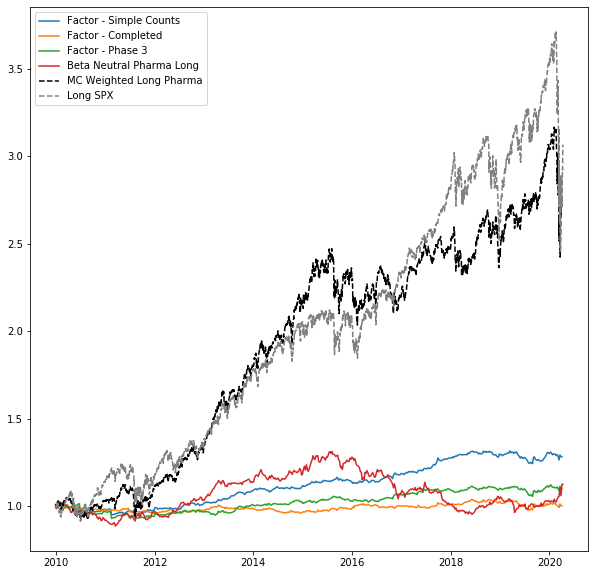

In [141]:
plt.figure(figsize=(10,10))
plt.plot(tri_fact_simple_counts, label='Factor - Simple Counts')
plt.plot(tri_fact_completed, label='Factor - Completed')
plt.plot(tri_fact_p3, label='Factor - Phase 3')
plt.plot(tri_hedged_pharma, label='Beta Neutral Pharma Long')
plt.plot(tri_mc_rt, label='MC Weighted Long Pharma', color='k', linestyle='--')
plt.plot(tri_spx, label='Long SPX', color='gray', linestyle='--')
plt.legend()
plt.show()

In [158]:
tri_spx

,Adj Close
Date,
2009-12-30,1.000000
2009-12-31,0.989958
2010-01-04,1.005883
2010-01-05,1.009029
2010-01-06,1.010015
...,...
2020-04-03,2.734255
2020-04-06,2.926595
2020-04-07,2.921935


In [165]:
def compute_sharpe(tri_series, resample='W-THU'):
    s_vol = tri_series.resample(resample).ffill().pct_change().std() * np.sqrt(52)
    y = (tri_series.index[-1] - tri_series.index[0]).days / 365.25
    s_rt = tri_series.values[-1] ** (1 / y) - 1
    return s_rt / s_vol

In [160]:
tri_fact_simple_counts.name = 'factor_simple_counts'
tri_fact_completed.name = 'factor_completed'
tri_fact_p3.name = 'factor_phase3'
tri_hedged_pharma.name = 'hedged_pharma'
tri_mc_rt.name = 'long_mc_pharma'
tri_spx.name = 'long_spx'

In [163]:
df_res_returns = pd.concat([tri_fact_simple_counts, 
                            tri_fact_completed,
                            tri_fact_p3,
                            tri_hedged_pharma,
                            tri_mc_rt,
                            tri_spx
                           ], axis=1).dropna()

In [164]:
compute_sharpe(df_res_returns)

factor_simple_counts    0.711959
factor_completed        0.012644
factor_phase3           0.256772
hedged_pharma           0.151764
long_mc_pharma          0.796342
long_spx                0.688181
dtype: float64

In [166]:
df_res_returns.to_pickle('res.p')